In [67]:
# import numpy as np
# import matplotlib.pylab as plt
# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 150
# import tidy3d as td
# import tidy3d.web as web

%load_ext autoreload
%autoreload 2

# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
# define spectral content of simulation
nm = 1e-3

Nf = 3
wvls = nm * np.linspace(550, 700, Nf)
wvl0 = np.mean(wvls)
print(wvl0)

freqs = td.C_0 / wvls
freq0 = td.C_0 / wvl0
fwidth = np.ptp(freqs)

0.625


In [69]:
# define substrate; make sure it extends well past the simulation domain
n = 2.0
material_substrate = td.Medium(permittivity=n**2)

substrate_height = 20
substrate_center_z = -10
substrate = td.Structure(
        geometry=td.Box(
            center=(0, 0, substrate_center_z),
            size=(td.inf, td.inf, substrate_height)),
        medium=material_substrate
)

In [70]:
# define LED stack

# radius = 9.0
radius = 2

# add dispersive materials here later
thicknesses = [1.2, 0.3, 0.1, .18, .15, 0.6, .1, 1, 1]
#thicknesses = [5]

#materials = ['AlGaInP', 'AlInP', 'SCL', 'MQW', 'SCL', 'AlInP', 'GaP', 'ITO']
#refinds = [3.49, 3.53635 + 1j*0.3075118, 1.5570, 2.6, 1.5570, 3.53635 + 1j*0.3075118, 3.375, 1.5]

materials = ['AlGaInP', 'AlInP', 'SCL', 'MQW', 'SCL', 'AlInP', 'AlGaInP', 'GaP', 'ITO']
refinds = [3.49, 3.53635 + 1j*0.3075118, 1.5570, 2.6, 1.5570, 3.53635 + 1j*0.3075118, 3.49, 3.375, 1.5]

led_total_height = np.sum(thicknesses)
led_stack = []
loc_z = substrate_center_z + substrate_height/2
for thick, name, nk in zip(thicknesses, materials, refinds):
    loc_z += thick / 2.0
    cyl = td.Structure(
        geometry=td.Cylinder(
            center=(0,0,loc_z),
            radius=radius,
            length=thick,
            axis=2),
        medium=td.Medium.from_nk(
            n=np.real(nk),
            k=np.imag(nk),
            freq=freq0
        ),
    )
    led_stack.append(cyl)
    loc_z += thick/2.0

# put all structures into a list
structures = [substrate] + led_stack

In [71]:
#%load_ext autoreload
#%autoreload 2

# standard python imports
#import numpy as np
#import matplotlib.pyplot as plt

# tidy3d imports
#import tidy3d as td
#import tidy3d.web as web

#z_val = 2.1
#cylinder = td.Cylinder(center=(0,0,z_val), radius=2, length=2, axis=2)
#ax = cylinder.plot(y=0)
#ax = cylinder.plot(z=z_val)

# plt.show()

In [72]:
# define source (point dipole in middle of MQW with Jx polarization

dipole_center_z = 0.0
for thick, name in zip(thicknesses, materials):
    dipole_center_z += thick/2.0
    if name == 'MQW':
        break
    dipole_center_z += thick/2.0

# dipole = td.PointDipole(
#     center=(0, 0, dipole_center_z),
#     component='Ex',
#     source_time=td.GaussianPulse(
#         frequency=freq0,
#         fwidth=fwidth
#     )
# )

gaussian = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
dipole_length = 0.1 * np.min(wvls)

dipole = td.VolumeSource(
    center=(0,0,dipole_center_z),
    #size=(dipole_length, 0.1 * dipole_length, 0),
    size=(0, 0, 0),
    source_time = gaussian,
    polarization='Ex')

sources = [dipole]

In [73]:
# define field monitors (box around LED with no bottom)

xy_buffer = 4

buffer_mon = .5 # space between structure and monitors
buffer_pml = 1. # space between structure and PML 
#xspan = 2 * radius + 2 * buffer_mon + 2 * xy_buffer
#yspan = 2 * radius + 2 * buffer_mon + 2 * xy_buffer
xspan = 2 * radius + 2 * buffer_mon + 2 * xy_buffer
yspan = 2 * radius + 2 * buffer_mon + 2 * xy_buffer
zstack = led_stack[-1].geometry.center[2] + led_stack[-1].geometry.length/2
zspan = zstack + 2 * buffer_mon
xmin, xmax = -xspan/2, xspan/2
ymin, ymax = -yspan/2, yspan/2
zmax = zstack + buffer_mon

mon = td.FieldMonitor(
    #center=[0, 0, zmax/2],
    #size=[xspan - 2 * xy_buffer, yspan - 2 * xy_buffer, zspan],
    center=[0, 0, 2.5],
    size=[4.5, 4.5, 5],
    freqs=freqs,
    name='mon',
)

monitors = mon.surfaces()
del monitors[-2]

mon_ymid = td.FieldMonitor(
    #center=[0, 0, zmax/2],
    #size=[xspan - 2 * xy_buffer, 0, zspan],
    center=[0, 0, 2.5],
    size=[4.5, 0, 5],
    freqs=freqs,
    name='mon_ymid',
)

monitors.append(mon_ymid)




#mon_top = td.FieldMonitor(
#    center=[0,0,zmax],
#    size=[xspan, yspan, 0],
#    freqs=freqs,
#    name='mon_z+',
#)

#mon_xmin = td.FieldMonitor(
#    center=[xmin,0,zmax/2],
#    size=[0, yspan, zspan],
#    freqs=freqs,
#    name='mon_x-',
#)

#mon_xmax = td.FieldMonitor(
#    center=[xmax,0,zmax/2],
#    size=[0, yspan, zspan],
#    freqs=freqs,
#    name='mon_x+',
#)

#mon_ymin = td.FieldMonitor(
#    center=[0,ymin,zmax/2],
#    size=[xspan, 0, zspan],
#    freqs=freqs,
#    name='mon_y-',
#)

#mon_ymax = td.FieldMonitor(
#    center=[0,ymax,zmax/2],
#    size=[xspan, 0, zspan],
#    freqs=freqs,
#    name='mon_y+',
#)

# Currently we only use the field on top of the structure for near2far
# We don't add the other monitors so that we don't have to download the data
#monitors = [mon_top, mon_ymid]


In [74]:
# simulation parameters (total size and grid size)
xspan = 2 * radius + 2 * buffer_pml + 2 * xy_buffer
yspan = 2 * radius + 2 * buffer_pml + 2 * xy_buffer
Lz = zstack + 2 * buffer_pml
dl = 20*nm

# create simulation object holding all specifications
pml_layers = 3*[td.PML()]
sim = td.Simulation(
    center=[0, 0, zstack/2],
    size=[xspan, yspan, Lz],
    grid_size=[dl, dl, dl],
    pml_layers=pml_layers,
    run_time=1e-12,
    structures=structures,
    sources=sources,
    monitors=monitors,
    #symmetries=(-1, 0, 0)
)


/Users/shashwat/Documents/flexcompute/repos/venvs/tidy3d-env/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


<Figure size 720x216 with 6 Axes>

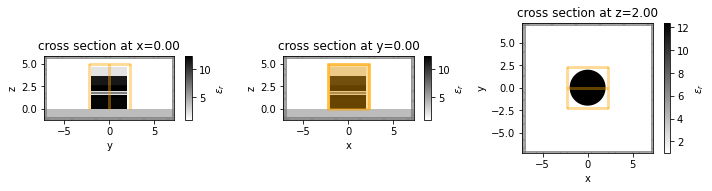

In [75]:
# plot structures along all three axes
# [print(struct.geometry.radius) for struct in led_stack]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
sim.plot_eps(x=0.0, ax=ax1);
sim.plot_eps(y=0.0, ax=ax2);
sim.plot_eps(z=2.0, ax=ax3);

#[struct.plot(x=0) for struct in led_stack]

#led_stack.plot(x=0)
#plt.show()

In [76]:
## run simulation, monitor status, and download results
#task_id = web.run(sim, task_name='LED')

# Run simulation
import tidy3d.web as web
sim_data = web.run(sim, task_name='led', path='data/led.hdf5')
# sim_data = web.load('3e650fd4-548e-4556-b38a-e473c3c53eb7', sim, path='data/simulation.hdf5')


[20:38:23] INFO     Uploaded task 'led' with task_id                            ]8;id=631857;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=121473;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#108\108]8;;\
                    '2946c190-8aea-4b0d-aa53-bcf69d057d27'.                                  

Output()

[20:38:24] status = queued                                                      ]8;id=167369;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=716779;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#202\202]8;;\

[20:38:42] status = preprocess                                                  ]8;id=672766;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=323493;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#202\202]8;;\

[20:39:08] status = running                                                     ]8;id=675429;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=955133;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#202\202]8;;\

[20:52:04] status = postprocess                                                 ]8;id=340306;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=520234;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#202\202]8;;\

[20:52:22] status = success                                                     ]8;id=235697;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=533887;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#202\202]8;;\

[20:52:22] INFO     downloading file "monitor_data.hdf5" to "data/led.hdf5"     ]8;id=966505;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=510414;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#483\483]8;;\

Output()

[20:53:39] INFO     loading SimulationData from data/led.hdf5                   ]8;id=747170;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=940746;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#302\302]8;;\

/Users/shashwat/Documents/flexcompute/repos/venvs/tidy3d-env/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/Users/shashwat/Documents/flexcompute/repos/venvs/tidy3d-env/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/Users/shashwat/Documents/flexcompute/repos/venvs/tidy3d-env/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


<Figure size 1080x252 with 6 Axes>

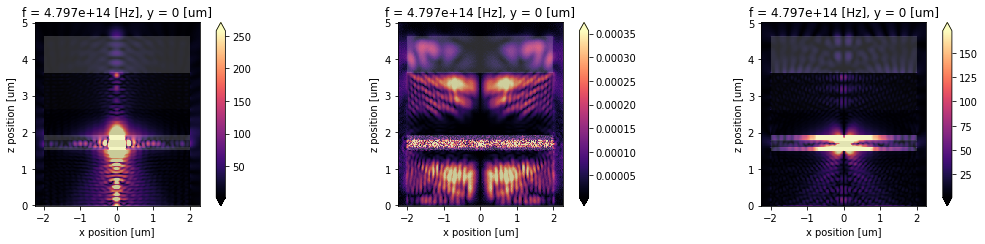

In [77]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

sim_data.plot_field(field_monitor_name='mon_ymid', field_name='Ex', y=0, val='abs', freq=freq0, ax=ax1)
sim_data.plot_field(field_monitor_name='mon_ymid', field_name='Ey', y=0, val='abs', freq=freq0, ax=ax2)
sim_data.plot_field(field_monitor_name='mon_ymid', field_name='Ez', y=0, val='abs', freq=freq0, ax=ax3)

plt.show()

In [84]:
# make angles and array for storing power
import copy
from tidy3d.plugins import Near2Far

r_far = 200 * wvl0

Ntheta = 100
Nphi = 100
thetas = np.linspace(0, np.pi, Ntheta)
phis = np.linspace(0, np.pi, Nphi)
power = np.zeros((Ntheta, Nphi))
rcs = np.zeros((Ntheta, Nphi))

# perform near field to far field transformation using the top monitor data
from rich.progress import track

near_mons = copy.deepcopy(monitors)
#del near_mons[-1]

n2f = Near2Far(sim_data, mons=near_mons, frequency=freq0)
for i in track(range(Ntheta), description='Performing far-field transformation...'):
    theta = thetas[i]
    for j, phi in enumerate(phis):
        rcs[i,j] = n2f.radar_cross_section(theta=theta, phi=phi)
        power[i,j] = n2f.power_spherical(r_far, theta=theta, phi=phi)

Output()

<Figure size 504x216 with 2 Axes>

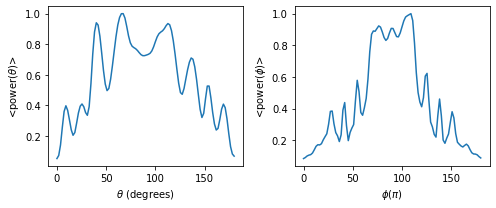

In [85]:
# plot the scattered power averaged over angles in spherical coordinates

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(7,3))
Ptheta = power.sum(axis=1)
ax1.plot(thetas*180/np.pi, Ptheta/np.amax(Ptheta))
#ax1.plot(thetas*180/np.pi, power[:,1]/np.amax(power[:,1]), '-b', label="$\\phi = 0$")
ax1.set_xlabel(r'$\theta$ (degrees)')
ax1.set_ylabel(r'<power($\theta$)>')

Pphi = power.sum(axis=0)
ax2.plot(phis*180/np.pi, Pphi/np.amax(Pphi))
ax2.set_xlabel(r'$\phi (\pi) $')
ax2.set_ylabel(r'<power($\phi$)>')

plt.show()


In [86]:
# compute far fields in Cartesian coordinates

far_plane_xy = 5.0

num_far_x = 40
num_far_y = 40
xs_n2f = far_plane_xy * np.linspace(-0.5, 0.5, num_far_x)
ys_n2f = far_plane_xy * np.linspace(-0.5, 0.5, num_far_y)
z_far = 200 * wvl0

# initialize the far field values
Es = np.zeros((3, num_far_x, num_far_y), dtype=complex)
Hs = np.zeros((3, num_far_x, num_far_y), dtype=complex)        
Ps = np.zeros((num_far_x, num_far_y), dtype=complex)

from rich.progress import track

# loop through points in the output plane
for i in track(range(num_far_x), description='Performing far-field transformation...'):

    x = xs_n2f[i]
    for j in range(num_far_y):
        y = ys_n2f[j]

        # compute and store the outputs from projection function at the focal plane
        E, H = n2f.fields_cartesian(x, y, z_far)
        Es[:, i, j] = np.squeeze(E)
        Hs[:, i, j] = np.squeeze(H)

        P = n2f.power_cartesian(x, y, z_far)
        Ps[i, j] = np.squeeze(P)


Output()

<matplotlib.colorbar.Colorbar object at 0x1288795b0>

<Figure size 288x216 with 2 Axes>

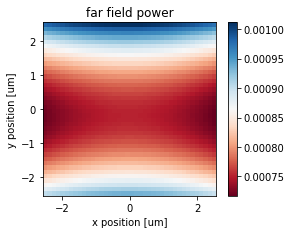

In [87]:
# Plot far field power

fig, (ax) =  plt.subplots(1, 1)
fig.set_size_inches(4, 3)
fig.tight_layout()

def pmesh(xs, ys, array, ax, cmap):
    im = ax.pcolormesh(xs, ys, array.T, cmap=cmap, shading='auto')
    return im

func = 'real'
def plotfunc(val):
    return np.real(val)

# Far field via near2far in the original simulation
im = pmesh(xs_n2f, ys_n2f, plotfunc(Ps), ax=ax, cmap='RdBu')
ax.set_title('far field power')
ax.set_aspect(1)
ax.set_xlabel('x position [um]')
ax.set_ylabel('y position [um]')
plt.colorbar(im, ax=ax)


<Figure size 864x216 with 6 Axes>

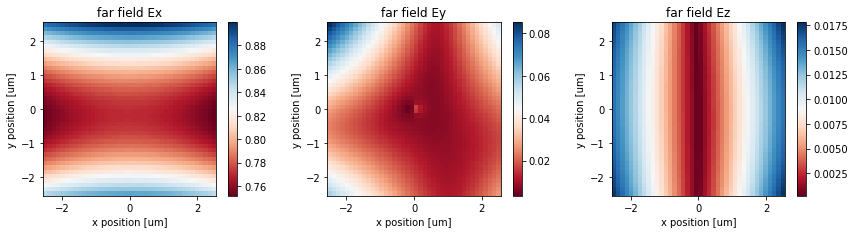

In [88]:
# Plot far fields

fig, (axes_far) =  plt.subplots(1, 3)
fig.set_size_inches(12, 3)
fig.tight_layout()

def pmesh(xs, ys, array, ax, cmap):
    im = ax.pcolormesh(xs, ys, array.T, cmap=cmap, shading='auto')
    return im

func = 'real'
def plotfunc(val):
    return np.abs(val)

for ax, direction, E in zip(axes_far, 'xyz', Es):
    im = pmesh(xs_n2f, ys_n2f, plotfunc(E), ax=ax, cmap='RdBu')
    ax.set_title(f'far field E{direction}')
    ax.set_aspect(1)
    ax.set_xlabel('x position [um]')
    ax.set_ylabel('y position [um]')
    plt.colorbar(im, ax=ax)
